In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: make plots look nicer
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


In [ ]:
# 1. Load JSONL
df = pd.read_json("../data/processed_articles_100k.jsonl", lines=True)

# 2. Quick look
print(df.shape)
print(df.columns.tolist())
df.head(3)


(165470, 6)
['date', 'title', 'overall_sentiment', 'overall_confidence', 'tickers', 'sectors']


,date,title,overall_sentiment,overall_confidence,tickers,sectors
0,2025-03-12 22:43:00+00:00,INVESTOR ALERT: Shareholder Class Action Lawsu...,Neutral,0.937435,"[{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...","[{'sector': 'Health Care', 'score': 0.0, 'labe..."
1,2025-03-10 21:01:00+00:00,Intuitive Machines Announces Completion of Red...,Positive,0.998596,"[{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...","[{'sector': 'Health Care', 'score': 0.0, 'labe..."
2,2025-02-14 18:14:00+00:00,INVESTOR ALERT: Shareholder Class Action Lawsu...,Neutral,0.966715,"[{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...","[{'sector': 'Health Care', 'score': 0.0, 'labe..."


In [ ]:
df["tickers"]

<bound method Series.view of 0         [{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...
1         [{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...
2         [{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...
3         [{'symbol': 'K', 'score': 0.0, 'label': 'Neutr...
4         [{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...
                                ...                        
165465    [{'symbol': 'A', 'score': 0.0, 'label': 'Neutr...
165466    [{'symbol': 'A', 'score': 0.5, 'label': 'Posit...
165467    [{'symbol': 'ABNB', 'score': 0.333333333333333...
165468    [{'symbol': 'A', 'score': 1.0, 'label': 'Posit...
165469    [{'symbol': 'A', 'score': 0.33333333333333304,...
Name: tickers, Length: 165470, dtype: object>

In [5]:
# 3. Column types + missingness
schema = pd.DataFrame({
    "column":     df.columns,
    "dtype":      df.dtypes.astype(str),
    "missing":    df.isna().sum(),
    "pct_missing": (df.isna().mean()*100).round(2)
})
schema


,column,dtype,missing,pct_missing
date,date,"datetime64[ns, UTC]",0,0.0
title,title,object,0,0.0
overall_sentiment,overall_sentiment,object,0,0.0
overall_confidence,overall_confidence,float64,0,0.0
tickers,tickers,object,0,0.0
sectors,sectors,object,0,0.0


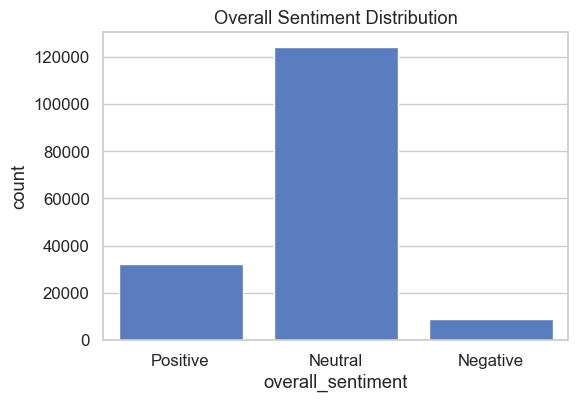

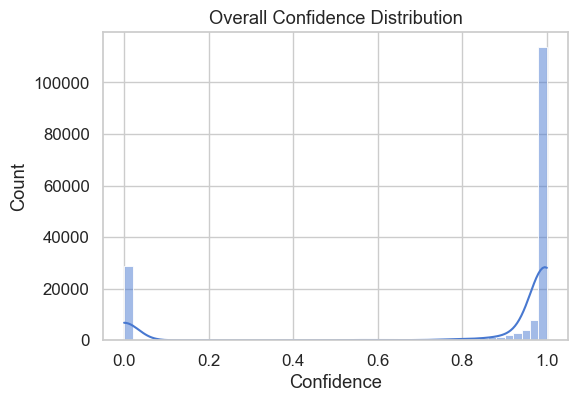

In [6]:
plt.figure(figsize=(6,4))
sns.countplot(x="overall_sentiment", data=df, order=["Positive","Neutral","Negative"])
plt.title("Overall Sentiment Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.histplot(df["overall_confidence"], bins=50, kde=True)
plt.title("Overall Confidence Distribution")
plt.xlabel("Confidence")
plt.show()


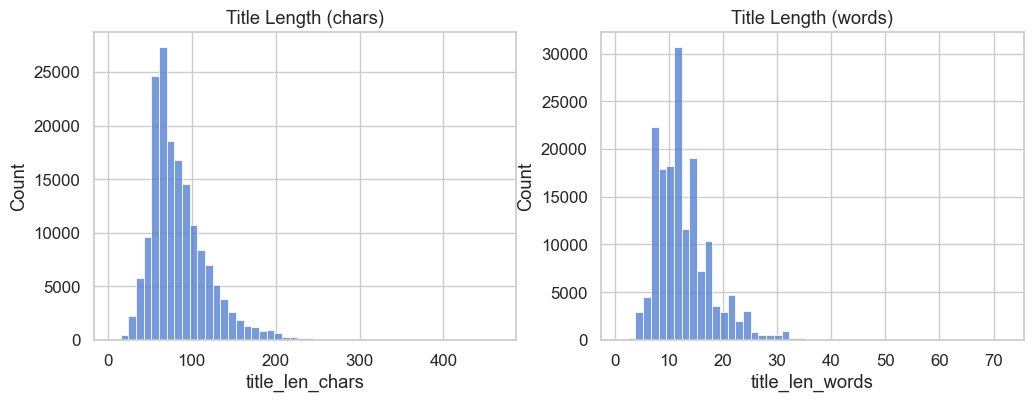

In [7]:
df["title_len_chars"] = df["title"].str.len()
df["title_len_words"] = df["title"].str.split().map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.histplot(df["title_len_chars"], bins=50, ax=axes[0])
axes[0].set_title("Title Length (chars)")
sns.histplot(df["title_len_words"], bins=50, ax=axes[1])
axes[1].set_title("Title Length (words)")
plt.show()


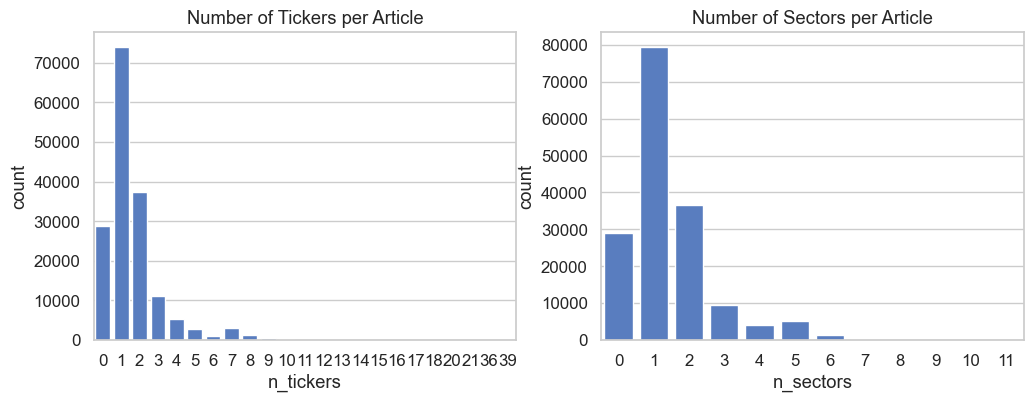

In [8]:
df["n_tickers"] = df["tickers"].map(len)
df["n_sectors"] = df["sectors"].map(len)

fig, axes = plt.subplots(1,2, figsize=(12,4))
sns.countplot(x="n_tickers", data=df, ax=axes[0])
axes[0].set_title("Number of Tickers per Article")
sns.countplot(x="n_sectors", data=df, ax=axes[1])
axes[1].set_title("Number of Sectors per Article")
plt.show()


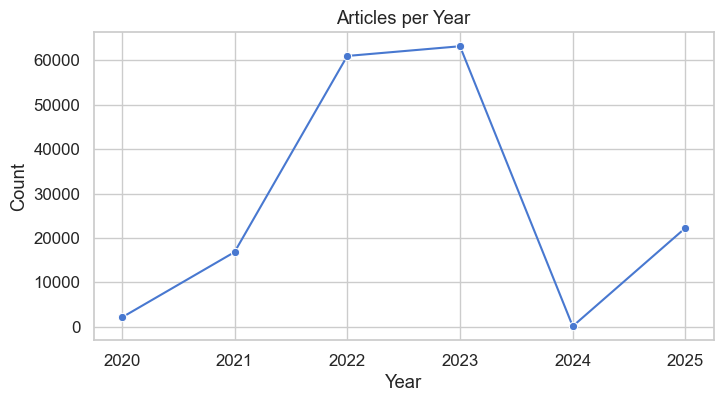

In [9]:
df["date"] = pd.to_datetime(df["date"])
yearly = df["date"].dt.year.value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.lineplot(x=yearly.index, y=yearly.values, marker="o")
plt.title("Articles per Year")
plt.ylabel("Count")
plt.xlabel("Year")
plt.show()


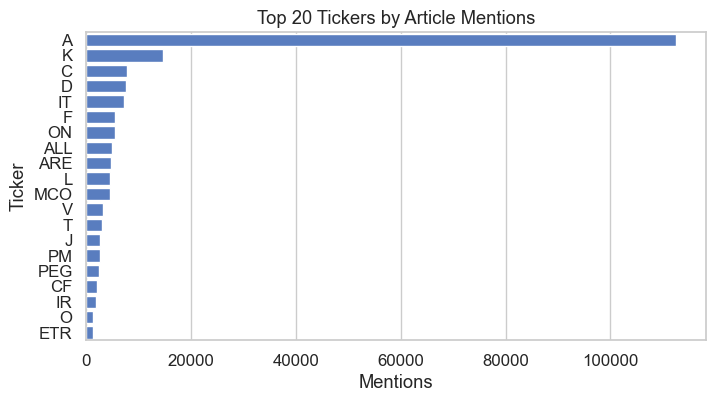

In [11]:
# 3.1 Flatten ticker list
tickers_flat = df["tickers"].explode().dropna().apply(pd.Series)

# 3.2 Top 20 tickers by article frequency
top20 = tickers_flat["symbol"].value_counts().head(20)
plt.figure(figsize=(8,4))
sns.barplot(x=top20.values, y=top20.index)
plt.title("Top 20 Tickers by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Ticker")
plt.show()


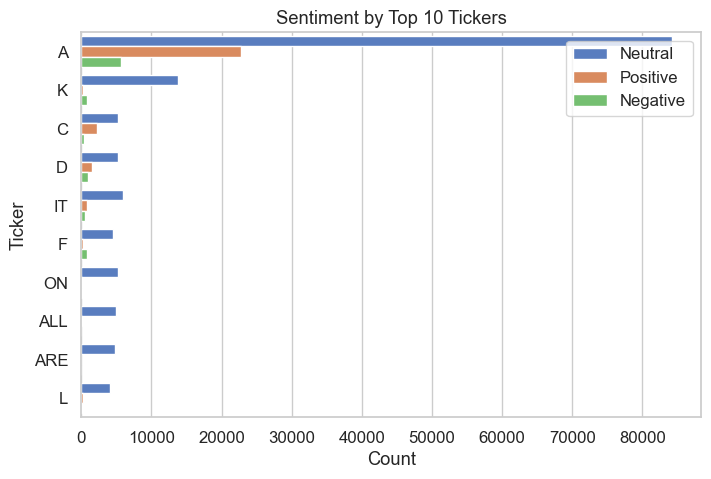

In [12]:
# 3.3 Sentiment breakdown per ticker (for top 10)
top_list = top20.index.tolist()[:10]
sub = tickers_flat[tickers_flat["symbol"].isin(top_list)]
plt.figure(figsize=(8,5))
sns.countplot(y="symbol", hue="label", data=sub, order=top_list)
plt.title("Sentiment by Top 10 Tickers")
plt.xlabel("Count")
plt.ylabel("Ticker")
plt.legend(loc="upper right")
plt.show()


In [13]:
# 3.4 Normalized sentiment ratio per ticker
ratio = (sub
         .groupby(["symbol","label"])
         .size()
         .unstack(fill_value=0)
         .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio.loc[top_list]


label,Negative,Neutral,Positive
symbol,,,
A,0.050262,0.747998,0.201740
K,0.051576,0.927496,0.020928
C,0.044196,0.668402,0.287402
D,0.116793,0.686372,0.196835
IT,0.068623,0.811659,0.119717
F,0.147465,0.810351,0.042184
ON,0.029655,0.948958,0.021387
ALL,0.004006,0.984979,0.011015
ARE,0.000831,0.992108,0.007061


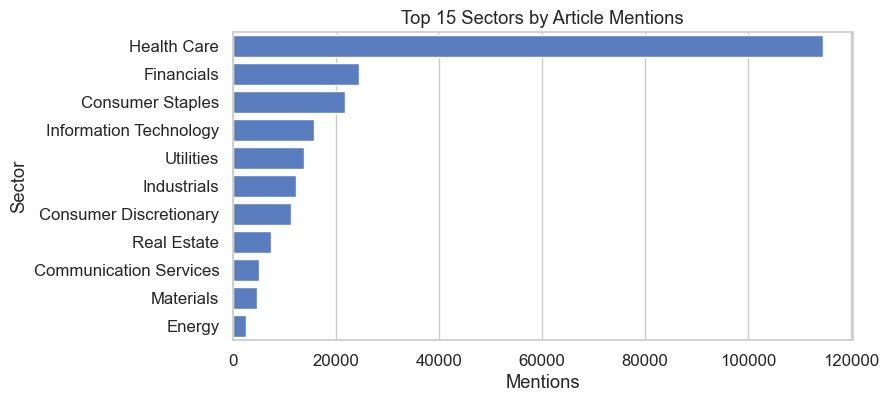

In [15]:
# 4.1 Flatten sectors
sectors_flat = pd.DataFrame(
	df["sectors"].explode().dropna().tolist()
)

# 4.2 Top sectors by mentions
topsec = sectors_flat["sector"].value_counts().head(15)
plt.figure(figsize=(8,4))
sns.barplot(x=topsec.values, y=topsec.index)
plt.title("Top 15 Sectors by Article Mentions")
plt.xlabel("Mentions")
plt.ylabel("Sector")
plt.show()


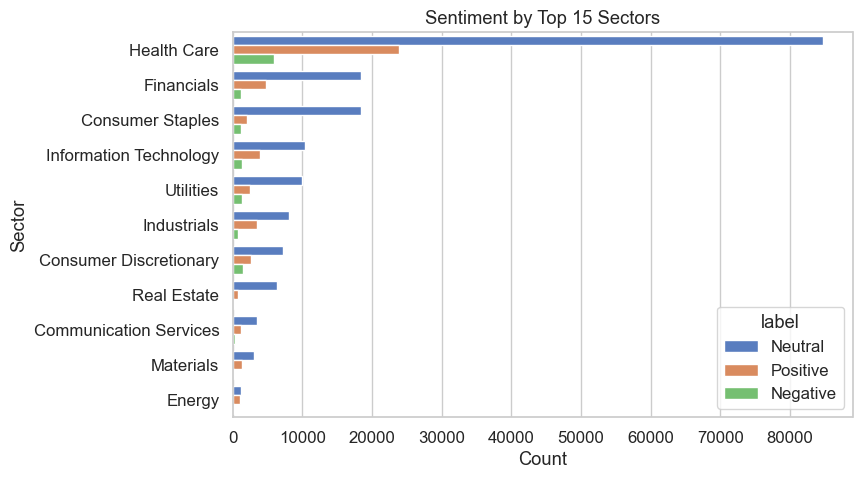

In [16]:
# 4.3 Sentiment breakdown for major sectors
maj = topsec.index.tolist()
sec_sub = sectors_flat[sectors_flat["sector"].isin(maj)]
plt.figure(figsize=(8,5))
sns.countplot(y="sector", hue="label", data=sec_sub, order=maj)
plt.title("Sentiment by Top 15 Sectors")
plt.xlabel("Count")
plt.ylabel("Sector")
plt.show()


In [17]:
# 4.4 Normalized sector sentiment ratios
ratio_sec = (sec_sub
             .groupby(["sector","label"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda df2: df2.div(df2.sum(axis=1), axis=0)))
ratio_sec.loc[maj]


label,Negative,Neutral,Positive
sector,,,
Health Care,0.051993,0.739728,0.208278
Financials,0.052211,0.751527,0.196261
Consumer Staples,0.055265,0.847150,0.097586
Information Technology,0.089351,0.660238,0.250411
Utilities,0.095857,0.717771,0.186372
Industrials,0.062890,0.651511,0.285599
Consumer Discretionary,0.130545,0.636189,0.233266
Real Estate,0.023180,0.873255,0.103565
Communication Services,0.076127,0.687057,0.236817


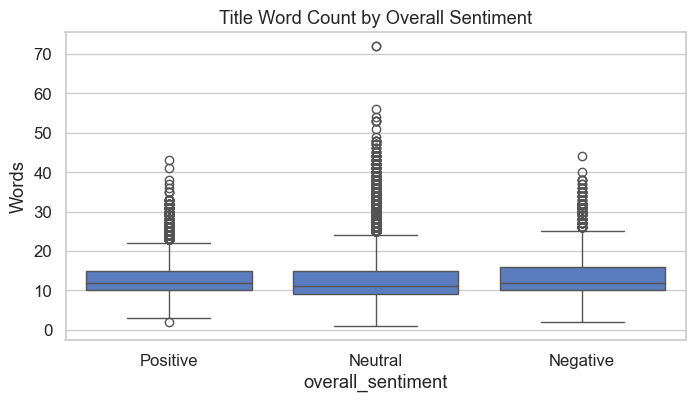

In [18]:
# Boxplot of title length by sentiment
plt.figure(figsize=(8,4))
sns.boxplot(x="overall_sentiment", y="title_len_words", data=df,
            order=["Positive","Neutral","Negative"])
plt.title("Title Word Count by Overall Sentiment")
plt.ylabel("Words")
plt.show()


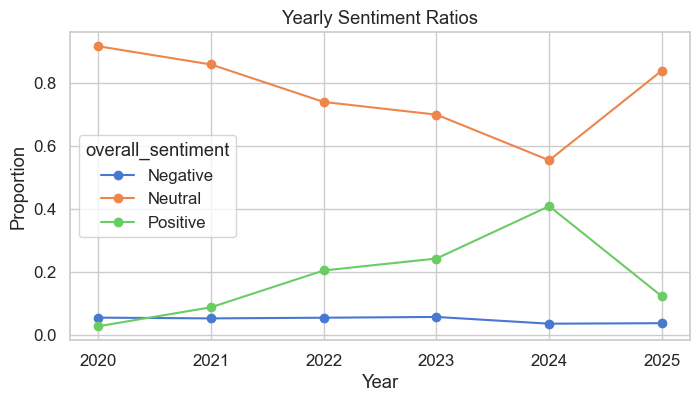

In [19]:
time_sent = (df
             .groupby([df["date"].dt.year, "overall_sentiment"])
             .size()
             .unstack(fill_value=0)
             .pipe(lambda x: x.div(x.sum(axis=1), axis=0)))
time_sent.plot(kind="line", marker="o", figsize=(8,4))
plt.title("Yearly Sentiment Ratios")
plt.ylabel("Proportion")
plt.xlabel("Year")
plt.show()


In [20]:
# Standard deviation of sentiment ratio across years
ticker_year = tickers_flat.copy()
ticker_year["year"] = df["date"].repeat(df["tickers"].str.len()).values
ty = (ticker_year
      .groupby(["symbol","year","label"])
      .size()
      .unstack(fill_value=0)
      .groupby(level=0)
      .apply(lambda d: d.div(d.sum(axis=1), axis=0))
      .groupby(level=0)
      .std())
ty["Positive"].sort_values(ascending=False).head(10)


symbol
VRSN    0.514496
UDR     0.511310
FTV     0.511310
FITB    0.511310
TRGP    0.510754
GDDY    0.509902
MKTX    0.508391
DOV     0.507875
BRO     0.507519
ZBRA    0.507416
Name: Positive, dtype: float64